We'll start simple. So simple you may wonder if it's AI at all. When building models from scratch, I like to start with the easiest thing possible and iterate. Before we write any code, let's define what machine learning and machine learning models are.

## What is machine learning?

Machine learning is a field of artificial intelligence focused on algorithms that 1) learn from data and 2) generalize to unseen data. There are three main components to machine learning, data, models, and algorithms. Machine learning models are the things that do the learning and the algorithms direct the models learning. The lines blur at times between models and algorithms and some algorithms only work for some models. At their core, models are functions. They take an input, process them in some way, and return an output. Models have learnable parameters and machine learning algorithms focus on adjusting these parameters to make the model produce better outputs.

Conceptually, models are simple. Take the equation for a line, `f(x) = m*x + b`. This is a model where `m` and `b` are constant values indicating the slope and y-intercept of the line. `x` is an input value and the output is `f(x) = y`. If we know `m` and `b` we can compute `y` for any `x`. Machine learning comes to the rescue when we don't know `m` and `b`. Assuming we have a bunch of `(x, y)` points, a machine learning algorithm can guess what good values for `m` and `b` are based on those points. Then we freeze those values and the model can predict `y` for any `x`.

Models can be giant equations and it's easy to get lost in the details, but remember _it's still just an equation!_ The learning algorithm will find the right constant terms for us. It's our job to set up the problem for the algorithm and model and then get out of the way so the machine can learn.

::: {.callout-note}
In machine learning, the constant terms of the equation are called parameters or weights. During training they are not constant as the learning algorithm is trying to find their optimal values, but once training is done these values become constant and you're left with a normal equation.
:::

### The learning process

At it's core the learning process iterates through prediction, comparison, and tweaking the model parameters. The training data is used in this process. We initialize the model, then use it as is to predict the outputs on the training data. These outputs are compared to the actual outputs, or targets, of the training data. If we are happy with the comparison, training is done. Otherwise the model parameters are adjusted and the process begins again. This whole process is outlined below.

```{mermaid}
flowchart TB
  B[Predict output for train data] --> C[Compare predictions to targets]
  C --> D{Predictions good enough?}
  D -- No --> E[Update model]
  D -- Yes --> F[Freeze model for production]
  E --> B
```

## The simplest of models

Turning our attention back to our model, the simplest thing we can do is predict the same thing for every input. And if we're going to predict the same thing for every input, it should be the most common thing.

This may seem silly, but it gives us a measuring stick to compare to other models. If we use the latest and greatest techniques in deep learning, it should outperform this model. The only way we'll know it outperforms it is by building the model and testing it. If it doesn't outperform this model, that raises cause for concern and the results should be investigated. So we start simple and incrementally improve until we are satisfied.

## Easy button

Throughout this book the first model in each chapter will be an existing implementation, where possible, that we can get up and running immediately. Then we'll implement the model ourselves to get a deeper understanding of what's going on.

### scikit-learn

[`scikit-learn`](https://scikit-learn.org/stable/index.html) is a widely used machine learning library. It comes fully loaded with all kinds of models and tools that let machine learning practitioners build models in just a few lines of code. And it turns out `scikit-learn` provides the simple model we want already as `sklearn.dummy.DummyClassifier`. This model is also referred to as a baseline model. Let's train it.

In [1]:
from sklearn.dummy import DummyClassifier
from nlpbook import get_train_test_data

train_df, test_df = get_train_test_data()
X, y = train_df[["review"]], train_df["label"]
cls = DummyClassifier().fit(X, y)
cls.score(X, y)

0.500803083841953

In four lines of code, we load the dataset, train the model, and evaluate it. Don't worry if it doesn't make sense, we'll go through it line by line.

#### Load the data

The first two lines load and prepare the data for training.

In [2]:
train_df, test_df = get_train_test_data()
X, y = train_df[["review"]], train_df["label"]

This book's companion Python package, `nlpbook`, comes with a helper function `get_train_test_data` which cleans up the data and returns it. Then the inputs and outputs for training are separated into their own variables, `X` and `y`, respectively. What do these inputs and outputs look like? In @sec-classification-dataset we saw the `review` column contains the review, this is our input. And the `label` column is a binary value, `0` or `1`, indicating if the review is negative or positive. There is something interesting going on with `X` though, why do we use double square brackets when accessing the `review` column? The double square bracket notation tells `pandas` to return a `DataFrame` instead of a `Series`, which begs another question, why a `DataFrame` instead of a `Series`?

A `DataFrame` is basically a matrix, while a `Series` is an array. In machine learning, inputs can have more than one feature and many algorithms and libraries expect inputs to be in the form of a matrix where the rows of the matrix are data points and the columns are features of each data point.[`DataFrame.shape` shows the dimensions of the matrix as `(rows, columns)`.]{.aside}

In [3]:
X.shape

(24904, 1)

In our case, we have 24,904 data points and each data point has one feature. That feature is the review. In practice, you'll use a matrix as input, even if you only have one feature.

Moving on to the output, why isn't `y` a matrix? Well it could be depending on your use case, but most of the time you will be predicting one value, so standard practice is to use an array. Each value in `y` corresponds to the output of each row in `X`. So, the first value in `y` is the output for the first row in `X`, the second value in `y` is the output for the second row in `X`, and so on.

#### Train the model

This line initializes the model and train it.

In [4]:
# | output: false
cls = DummyClassifier().fit(X, y)

With `scikit-learn` you'll see a few methods over and over again, `fit` is one of those methods. `fit` just means train the model. We are "fitting" the model to the data. `scikit-learn` models returns `self` from `fit`, so we can initialize the model and train it in one line.

#### Evaluate the model

Finally the model is evaluated with `score`.

In [5]:
cls.score(X, y)

0.500803083841953

What is this score though? It's a metric that evaluates the performance of the model.

## Metrics, metrics, metrics

Metrics give a sense of how well your model is doing. They allow you to measure and compare models. There is no one size fits all metric, and you'll usually want to look at multiple metrics when evaluating models. I recommend starting with the end when picking metrics. Why are you building this model in the first place? What is it you want the model to do? Then define your metrics with that objective in mind.

### Accuracy

We are trying to predict the sentiment of movie reviews. We don't care about positive vs negative, we just care that we get it right. It's a simple question, "How many predictions are correct?" This is accuracy. It's measured as a ratio, the number of correct predictions over all predictions.

In [1]:
import numpy as np

def accuracy(y, y_pred):
    # Convert to numpy arrays for convenience.
    y, y_pred = np.array(y), np.array(y_pred)
    # Create an array of boolean values indicating if
    # `y` and `y_pred` are the same at each index.
    is_equal = y == y_pred
    # Sum the `True` values.
    correct = np.sum(is_equal)
    # Return the ratio of correct over total.
    return correct / len(y)

accuracy([0, 1, 1], [1, 1, 1])

np.float64(0.6666666666666666)

In the simple example above there are two lists where the difference between them is at the first element. Two out of three are the same and that's exactly what accuracy tells us.

In practice, we don't have to write our own accuracy function because `scikit-learn` offers one.

In [7]:
from sklearn.metrics import accuracy_score

# Check our accuracy function returns the same value as `sklearn`s.
accuracy([0, 1, 1], [1, 1, 1]) == accuracy_score([0, 1, 1], [1, 1, 1])

np.True_

Back to our classifier! When we ran `cls.score(X, y)`, the model returned the accuracy. We can check this by computing the accuracy ourselves.

In [8]:
predictions = cls.predict(train_df)
accuracy_score(y, predictions), cls.score(X, y)

(0.500803083841953, 0.500803083841953)

Our accuracy is `0.5` out of `1.0`, or 50% , which means we got half of the predictions correct.[The accuracy score is on a 0-1 scale where 1 means 100% accuracy]{.aside} This makes sense since our dataset is half positive and half negative labels, so if we predict `0` or `1` for everything we should get half of them correct.

#### Imbalanced datasets and accuracy

Metrics are not foolproof. What is "good" for one dataset may not be for another. This is why we start with the simplest possible model. Because it allows us to establish minimum benchmarking values to compare against. Let's run through an example to show how accuracy changes with the ratio of positive to negative labels in the dataset using this simple model.[I love [`seaborn`](https://seaborn.pydata.org/) for rapid data visualization. It can't do everything perfectly, but it does the common things beautifully.]{.aside}

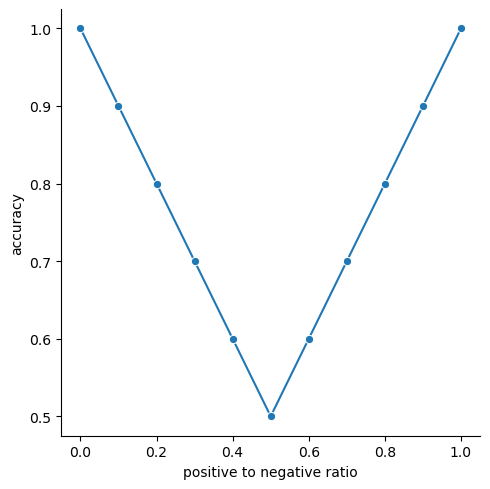

In [9]:
# | echo: false
import pandas as pd
import seaborn as sns


model = DummyClassifier()
data = []
N = 10
for i in range(0, N + 1):
    labels = [1] * i + [0] * (N - i)
    model.fit(labels, labels)
    data.append(
        {
            "positive to negative ratio": i / N,
            "accuracy": model.score(labels, labels),
        }
    )

sns.relplot(
    pd.DataFrame(data),
    x="positive to negative ratio",
    y="accuracy",
    kind="line",
    markers=True,
    marker="o",
)

The accuracy of our model is 50% when we have a 50/50 ratio of positive to negative labels. As the ratio moves to either extreme however (all ones or all zeros), the accuracy goes up until it reaches 100% when all the labels in the dataset are the same.

Intuitively a higher accuracy is better, but it might not be high because your model works well. It could be that your dataset is imbalanced and your model has figured that out and predicts everything to be the majority class. In that scenario, you end up with a fancy model you put all this effort into just to get the same result as the simple model we just made. How do you combat this? By doing what we've done here and start with a simple model. Then as you develop more complex models, they can be compared to this simple model to see if they make improvements!

### Other metrics

Accuracy is not the only thing we can measure, but for simplicities sake it will be the only thing we measure in this book. Other common metrics we could look at are F1-score and Matthews Correlation Coefficient (MCC), but there's plenty more.

## Train vs. test datasets

We've trained a model and evaluated it's accuracy so now we can move on to making a better model. WRONG, WE HAVEN'T EVALUATED THE MODEL!!! We checked the accuracy on the _training data_ which isn't a true evaluation of the model. We want to know how well our model works _on data it hasn't seen yet_, which is why we have a test set. The test set is used exclusively to benchmark the performance of the model and is not used in the training process. This comes back to making models that generalize to unseen data. Models generally perform better on data they're trained on because that data is what the model is optimized to predict for. If we use that same data to test the model, then we'll likely be overconfident in our models predictions. When we deploy the model and it is used on new data it hasn't seen we'll be in for a rude awakening. So we separate our dataset into training and testing datasets. In practice care should go into how these datasets are curated[I highly recommend this [blog post](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on the dangers of blindly splitting your data. It is about validation sets, but the same concepts apply to test sets.]{.aside}, but we won't worry about that here since I've already cleaned our datasets.

So let's evaluate our model for real.

In [10]:
X_test, y_test = test_df[["review"]], test_df["label"]
cls.score(X_test, y_test)

0.5011190233977619

The accuracy is still `0.5` which makes sense. The test dataset is curated the same way as the train dataset and has a roughly 50/50 split of positive to negative labels. While the accuracy didn't change between the train and test datasets, we have a more unbiased evaluation of our model and this is the accuracy we will aim to beat next.

## Preprocessing

When we prepared our training data, we ran this code:

In [11]:
X, y = train_df[["review"]], train_df["label"]

All we did was pull out the relevant columns from the dataframe, which is as simple as it gets. Preprocessing can get very complicated and we'll explore how preprocessing impacts model performance in future chapters. One important aspect of preprocessing is the test dataset needs to be preprocessed _the same way_ as the train dataset, because the model expects the data it makes predictions about to have the same form as the data it was trained on.

## Rolling our own

Now that we've trained a model, let's make it ourselves. It's as simple as you can get, majority rules.[Model implementations will include gratuitous comments explaining the code. This is a more streamlined approach that allows for covering the abstract concepts in the chapter text while giving details on implementation alongside the implementation itself.]{.aside}

In [12]:
class BaselineClassifier:
    def fit(self, X, y):
        """Train the model with inputs `X` on labels `y`."""
        # Get the unique labels and their counts.
        labels, counts = np.unique(y, return_counts=True)
        # Keep the most common label for prediction.
        self.prediction = labels[np.argmax(counts)]
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Return the most common label as the prediction for every
        # input.
        return np.full(len(X), self.prediction)


bc = BaselineClassifier()
bc.fit(X, y)
accuracy_score(y_test, bc.predict(X_test))

0.5011190233977619

Beautiful, we got the same score. But wait, there's more!

## scikit-learnifying our model {#sec-scikit-learnifying-our-model}

`scikit-learn` provides a framework to integrate your own machine learning models to leverage all the bells and whistles provided by their API. One such benefit is benchmarking. `scikit-learn` models come with a `score` method, and the default `score` method for classifiers is accuracy. By wrapping our model in `scikit-learn`s framework, we get accuracy scores (and a bunch of other stuff) for free.

### scikit-learn best practices

There's a [pretty lengthy document](https://scikit-learn.org/stable/developers/develop.html) on developing `scikit-learn` models, but most of the advice on that page can be boiled down to a few points.

- `__init__` is for setting attributes, not computation.
- Every parameter for `__init__` should have a corresponding attribute.
- Computation during training that needs to persist across method calls should be assigned to attributes with an underscore suffix.
- The `fit` method is for training and the `predict` method is for prediction.
- `fit` should return `self`.
- `BaseEstimator` should be to the right of `scikit-learn` mixins.
- Must accept `N` data points at once.

A note on that last point, accepting multiple data points at once comes with two benefits.

1. Multiple data points can be predicted at once.
2. Operating on multiple data points at once allows for leveraging highly optimized libraries, like `numpy`, for improved speed.

With a few tweaks, our `BaselineClassifier` becomes a `scikit-learn` model.

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin


class BaselineClassifier(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Train the model with inputs `X` on labels `y`."""
        # Get the unique labels and their counts.
        labels, counts = np.unique(y, return_counts=True)
        # Keep the most common label for prediction.
        # Note we changed the `prediction` attribute to include a
        # trailing suffix because it results from a computation
        # that persists across method calls.
        self.prediction_ = labels[np.argmax(counts)]
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Return the most common label as the prediction for every
        # input.
        return np.full(len(X), self.prediction_)


cls = BaselineClassifier().fit(X, y)
cls.score(X_test, y_test)

0.5011190233977619

And with that we get accuracy for free. Thanks `scikit-learn`.

## Multiclass classification

Up to this point we've dealt with binary classification, the label is either `0` or `1`, but classification can extend to 3 or more labels. Our dataset includes ratings which we can use as multiclass labels. Fortunately, we've written `BaselineClassifier` to work on an arbitrary number of labels, so we should get multiclass classification for free. Let's see what happens when we use the `rating` column instead of the `label` column.

In [14]:
cls = BaselineClassifier().fit(X, train_df["rating"])
cls.score(X_test, test_df["rating"])

0.1997151576805697

At first glance this may seem low, but if you take a second to think about it, it actually makes sense. As the number of unique labels goes up, the frequency of the majority label is more likely to go down. Let's look at the breakdown of ratings frequency.

In [15]:
train_df.groupby("rating").size() / len(train_df)

rating
1     0.203501
2     0.091230
3     0.096852
4     0.107613
7     0.100104
8     0.120704
9     0.090548
10    0.189447
dtype: float64

Here we see the most frequent label shows up 20% of the time, which is inline with our accuracy on the test set. Good thing we have a baseline model to orient us as we think about accuracy on binary and multiclass classification problems!